### Functions

In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import keras.layers.advanced_activations as advanced_activations
import keras.activations as activations
import keras.layers as layers
from keras.layers import Dense, concatenate

In [ ]:
import scipy.spatial.distance as distance
def plot_mat_accuracy(input, y_hat, y_true):

  input = input
  y_hat = y_hat
  y_true = y_true

  dist = distance.cosine(y_hat.flatten(), y_true.flatten())

  fig, axs = plt.subplots(1,3)
  fig.suptitle('Accuracy: {}'.format(1 - dist))
  
  axs[0].set_title("Input")
  axs[0].matshow(input)

  axs[1].set_title("Y_hat")
  axs[1].matshow(y_hat)

  axs[2].set_title("Y_true")
  axs[2].matshow(y_true)
  
  for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

  plt.show()
      
  return 1 - dist

def get_mat_accuracy(y_hat, y_true):
  dist = distance.cosine(y_hat.flatten(), y_true.flatten())
  return 1 - dist

### Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd drive/My\ Drive/SWE

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/SWE


In [ ]:
portate = np.load('datasets/numpy/portate.npy')
print(portate.shape)

binaries = np.load('datasets/numpy/binaries.npy')
print(binaries.shape)

btms = np.load('datasets/numpy/btms.npy')
print(btms.shape)

(100, 1, 3)
(100, 1, 443, 640)
(100, 1, 448, 640)


### Data Preprocessing


#### Resizing

In [ ]:
from skimage.transform import resize

In [ ]:
FACTOR = 0.3

binaries = np.array(
    [resize(s[0], (int(s[0].shape[0] * FACTOR), int(s[0].shape[1] * FACTOR))) for s in binaries]
)

btms = np.array(
    [resize(s[0], (int(s[0].shape[0] * FACTOR), int(s[0].shape[1] * FACTOR))) for s in btms]
)

In [ ]:
print(binaries.shape)
print(btms.shape)

(100, 132, 192)
(100, 134, 192)


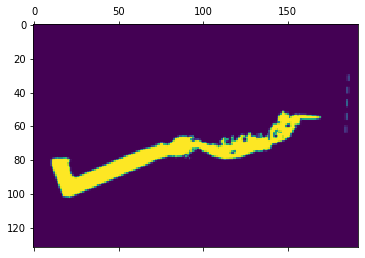

In [ ]:
plt.matshow(binaries[0])

#### Concatenating

In [ ]:
model_in_shape = portate.shape[2] + (btms.shape[1] * btms.shape[2])
model_out_shape = binaries.shape[1] * binaries.shape[2]

In [ ]:
# 100, model_in_shape (es: 300x300 + 3)
inputs = np.zeros((portate.shape[0], model_in_shape))
img_shape = model_in_shape - portate.shape[2]

for i in range(100):
  # Copia immagine flattened
  inputs[i][:img_shape] = btms[i].flatten()
  # Copia dati portata
  inputs[i][img_shape:] = portate[i][0]

In [ ]:
TRAIN_SIZE = int(inputs.shape[0] * 0.8)

x_train, y_train = inputs[:TRAIN_SIZE], binaries[:TRAIN_SIZE]
x_test, y_test = inputs[TRAIN_SIZE:], binaries[TRAIN_SIZE:]

### Feed Forward

In [ ]:
model = Sequential(
    [
        layers.Input(model_in_shape),
        layers.BatchNormalization(),
     
        layers.Dense(128),
        layers.BatchNormalization(),
     
        layers.Dense(256),
        layers.BatchNormalization(),
     
        layers.Dense(128),
        layers.BatchNormalization(),
     
        layers.Dense(model_out_shape),
        layers.Activation(activations.sigmoid),
     
        layers.Reshape((binaries.shape[1], binaries.shape[2]))
     
    ]
)

model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["cosine_similarity"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 25731)             102924    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                1646848   
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256       
_________________________________________________________________
dense_17 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512       
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)               

In [ ]:
epochs = 100

model.fit(
    x_train,
    y_train,
    batch_size=4,
    epochs=epochs,
    verbose=2,
    shuffle=1,
    validation_split=0.2,
)

Epoch 1/100
16/16 - 1s - loss: 0.6791 - cosine_similarity: 0.2924 - val_loss: 0.8501 - val_cosine_similarity: 0.2964
Epoch 2/100
16/16 - 0s - loss: 0.6621 - cosine_similarity: 0.2973 - val_loss: 1.1291 - val_cosine_similarity: 0.2075
Epoch 3/100
16/16 - 0s - loss: 0.6454 - cosine_similarity: 0.3018 - val_loss: 1.4964 - val_cosine_similarity: 0.1637
Epoch 4/100
16/16 - 0s - loss: 0.6217 - cosine_similarity: 0.3095 - val_loss: 2.2763 - val_cosine_similarity: 0.1153
Epoch 5/100
16/16 - 0s - loss: 0.5755 - cosine_similarity: 0.3218 - val_loss: 3.3766 - val_cosine_similarity: 0.0960
Epoch 6/100
16/16 - 0s - loss: 0.5097 - cosine_similarity: 0.3397 - val_loss: 4.6736 - val_cosine_similarity: 0.0895
Epoch 7/100
16/16 - 0s - loss: 0.4254 - cosine_similarity: 0.3685 - val_loss: 6.3560 - val_cosine_similarity: 0.0898
Epoch 8/100
16/16 - 0s - loss: 0.3459 - cosine_similarity: 0.3964 - val_loss: 7.6632 - val_cosine_similarity: 0.0918
Epoch 9/100
16/16 - 0s - loss: 0.2753 - cosine_similarity: 0.423

In [ ]:
# btms 0 + portate 0
index = 0
res = model.predict(np.array([x_test[index]]))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


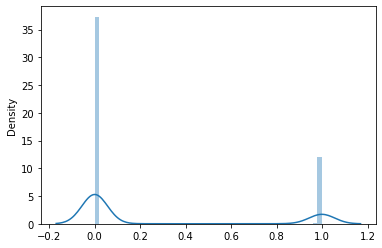

In [ ]:
# Noto che la rete ha polarizzato i valori! (YAY!)
sns.distplot(res[0].flatten())

In [ ]:
THRSHLD = 0.8

res[res >= THRSHLD] = 1
res[res < THRSHLD] = 0

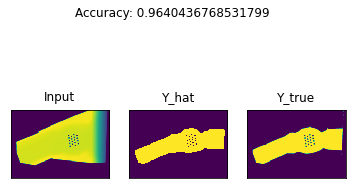

0.9640436768531799

In [ ]:
plot_mat_accuracy(
    x_test[index][:img_shape].reshape(btms.shape[1], btms.shape[2]),
    res[0],
    y_test[index]
)

In [ ]:
# Test Loss
test_losses = np.zeros(x_test.shape[0])

for i, x in enumerate(x_test):
  y_hat = model.predict(np.array([x]))
  y_true = y_test[i]

  test_losses[i] = get_mat_accuracy(y_hat, y_true)

# Train loss
train_losses = np.zeros(x_train.shape[0])

for i, x in enumerate(x_train):
  y_hat = model.predict(np.array([x]))
  y_true = y_train[i]

  train_losses[i] = get_mat_accuracy(y_hat, y_true)


print("Train accuracy: {}".format(train_losses.mean()))
print("Test accuracy: {}".format(test_losses.mean()))

Train loss: 0.9732487395405769
Test loss: 0.9602359175682068


#### Considerazioni
- L'attivazione ReLU "taglia" dei valori intermedi, la rete impara di conseguenza a prevedere SOLO la matrice binaria finale per tutti gli step
- La BatchNormalization() ad ogni livello migliora le prestazioni
- La sigmoid ad ogni livello migliora le prestazioni
- I valori predetti sono polarizzati tra 0 e 1, ho applicato una trasformazione in post per convertirli in binario
- Con troppi neuroni il modello pensa ci siano piú celle allagate del previsto
- Inaspettatamente, con molti meno neuroni la rete lavora meglio. Dimostra che non c'é una relazione lineare tra la dimensione input e la dimensione della rete
- Valutare ACCURACY e provare ad applicare un layer custom che approssimi i valori binari

#### Grid search
- Caso 1
  - layers: 2048-4096-2048
  - Train loss: 0.9599439859390259
  - Test loss: 0.7443766593933105
- Caso 2
  - layers: 1024-2048-1024
  - Train loss: 0.9633248627185822
  - Test loss: 0.9483283877372741
- Caso 3
  - layers: 1024-1024-1024
  - Train loss: 0.9602072075009346
  - Test loss: 0.7796615689992905
- Caso 4
  - layers: 256-512-256
  - Train loss: 0.9725818052887917
  - Test loss: 0.972408851981163
- Caso 5
  - layers: 128-256-128
  - Train loss: 0.9711698390543461
  - Test loss: 0.9726134836673737
- Caso 6
  - layers: 64-128-64
  - Train loss: 0.9732487395405769
  - Test loss: 0.9602359175682068
